In [2]:

import datetime
import os
import cv2
import glob
import h5py
import sys
import optparse
import copy

import pylab as pl
from collections import Counter
import seaborn as sns

import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import tifffile as tf

from pipeline.python.classifications import test_responsivity as resp #import calculate_roi_responsivity, group_roidata_stimresponse, find_barval_index
#from pipeline.python.classifications import osi_dsi as osi
#from pipeline.python.visualization import get_session_summary as ss
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.retinotopy import fit_2d_rfs as rf

from pipeline.python.utils import uint16_to_RGB
from skimage import exposure
from matplotlib import patches

from scipy import stats
from scipy.interpolate import interp1d
import scipy.optimize as spopt

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    

In [3]:
%matplotlib notebook

# Load sample data

In [4]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' 
session = '20190522' #'20190319'
fov = 'FOV1_zoom2p0x' 
run = 'combined_gratings_static'
traceid = 'traces001' #'traces002'
trace_type = 'corrected'

data_identifier = '|'.join([animalid, session, fov, run, traceid])

create_new=True
n_processes=1

In [5]:
traceid_dir =  glob.glob(os.path.join(rootdir, animalid, session, fov, run, 'traces', '%s*' % traceid))[0]
data_fpath = glob.glob(os.path.join(traceid_dir, 'data_arrays', 'datasets.npz'))[0]
dset = np.load(data_fpath)

data_identifier = '|'.join([animalid, session, fov, run, traceid])



In [6]:
dset.keys()

['zscore',
 'dff',
 'ylabels',
 'corrected',
 'labels_columns',
 'sconfigs',
 'run_info',
 'meanstim',
 'labels_data']

In [7]:
# dff_df = corrected_df/F0_df
F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )
print("offset: %.2f" % F0)

offset: 644.22


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [8]:
raw_traces = pd.DataFrame(dset['corrected']) + F0

In [9]:
labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
sdf = pd.DataFrame(dset['sconfigs'][()]).T

fr = 44.65 #dset['run_info'][()]['framerate']
nframes_on = labels['nframes_on'].unique()[0]
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_post_onset = nframes_on + int(round(1.*fr))


In [179]:
reload(resp)

<module 'pipeline.python.classifications.test_responsivity' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py'>

In [10]:
gdf = resp.group_roidata_stimresponse(raw_traces.values, labels, return_grouped=True) # Each group is roi's trials x metrics
#gdf = resp.get_roi_response_by_trial(raw_traces.values, labels)
#gratings_df_by_rois.get_group(roi_list[0])
nrois_total = len(gdf.groups)



# Look at distribution of response values

In [10]:
stim = np.array([gdf.get_group(r).groupby(['config']).mean()['dff'] for r in range(nrois_total)]).ravel()
bas = np.array([gdf.get_group(r).groupby(['config']).mean()['base_mean'] for r in range(nrois_total)]).ravel()

<IPython.core.display.Javascript object>


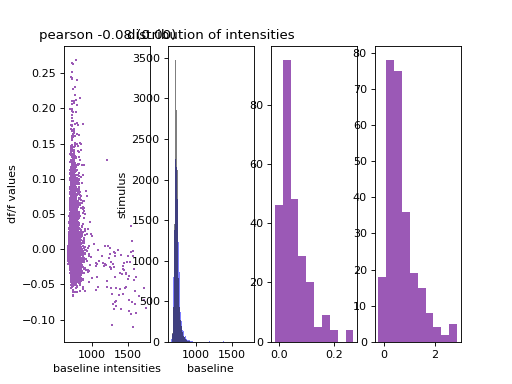

(array([ 18.,  78.,  75.,  36.,  19.,  15.,   8.,   4.,   2.,   5.]),
 array([-0.22693158,  0.08111417,  0.38915992,  0.69720566,  1.00525141,
         1.31329715,  1.6213429 ,  1.92938865,  2.23743439,  2.54548014,
         2.85352589]),
 <a list of 10 Patch objects>)

In [183]:
fig, axes = pl.subplots(1,4)

ax = axes[0]
ax.scatter(bas, stim, marker='+', s=1)
r, p = stats.pearsonr(bas, stim)
ax.set_title('pearson %.2f (%.2f)' % (r, p))
ax.set_xlabel('baseline intensities')
ax.set_ylabel('df/f values')

ax = axes[1]
stim_means = np.array([gdf.get_group(r).groupby(['config']).mean()['stim_mean'] for r in range(nrois_total)]).ravel()
ax.hist(stim_means, alpha=0.5, color='b', label='stimulus', bins=100)
ax.hist(bas, alpha=0.5, color='k', label='baseline', bins=100)
ax.set_title('distribution of intensities')
ax.set_xlabel('baseline')
ax.set_ylabel('stimulus')

ax= axes[2]
stim_df = np.array([gdf.get_group(r).groupby(['config']).mean()['stim_mean_df'].max() for r in range(nrois_total)]).ravel()
#bas_df = np.array([gdf.get_group(r).groupby(['config']).mean()['bas_mean_df'] for r in range(nrois_total)]).ravel()
#ax.scatter(bas_df, stim_df, marker='+', s=1)
ax.hist(stim_df)

ax = axes[3]
zscores = np.array([gdf.get_group(r).groupby(['config']).mean()['zscore'].max() for r in range(nrois_total)]).ravel()
ax.hist(zscores)

In [184]:
zscores.min(), zscores.max()

(-0.22693157638307665, 2.8535258858077679)

In [185]:
np.where(zscores==zscores.max())

(array([234]),)

In [186]:
snrs = np.array([gdf.get_group(r).groupby(['config']).mean()['snr'].max() for r in range(nrois_total)]).ravel()
snrs.max()

1.2679925523187023

In [187]:
snrs.min()

0.98668616719985458

In [188]:
np.where(stim_df == stim_df.max())

(array([137]),)

In [120]:
mean_stim = np.array([gdf.get_group(r).groupby(['config']).mean()['meanstim'].max() for r in range(nrois_total)]).ravel() 
dff_f0 = np.array([ (f-F0 / F0) for f in mean_stim])
dffs = np.array([gdf.get_group(r).groupby(['config']).mean()['dff'].max() for r in range(nrois_total)]).ravel() 

In [121]:
dff_f0.max(), dff_f0.min()

(1644.7716003068531, 669.09758232710647)

<IPython.core.display.Javascript object>


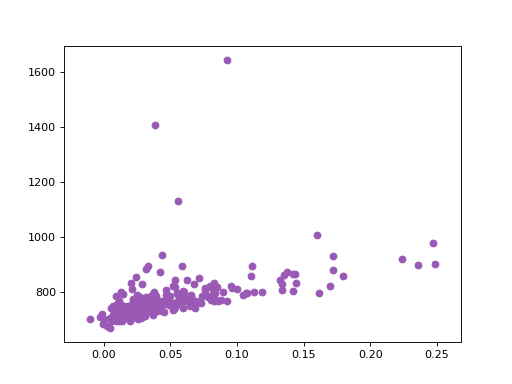

In [118]:
pl.figure()
pl.scatter(dffs, dff_f0)

<IPython.core.display.Javascript object>


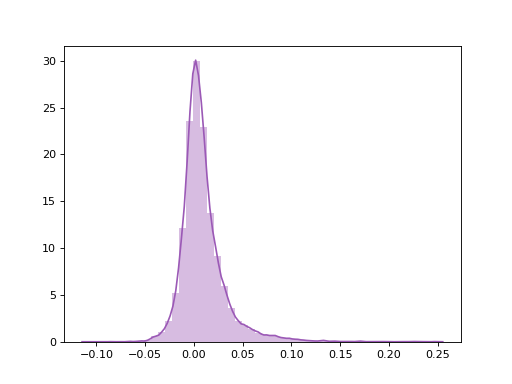

In [108]:
pl.figure()
sns.distplot(stim.ravel())

In [ ]:
gdf.get_group(151).groupby(['config']).mean()['dff']

In [80]:
gdf.get_group(30).groupby(['config']).mean()['dff'].max()

0.13353165641005438

<IPython.core.display.Javascript object>


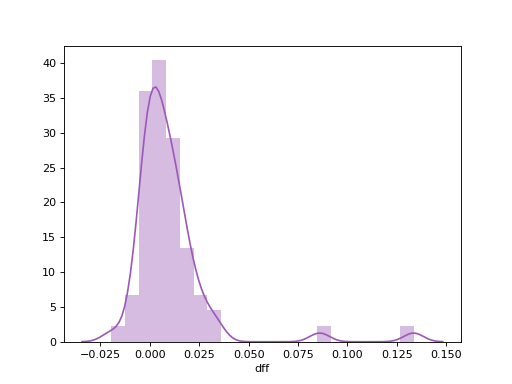

In [78]:
pl.figure();
sns.distplot(gdf.get_group(30).groupby(['config']).mean()['dff'])

#### Filter cells by responsivity

In [11]:
import cPickle as pkl


In [12]:
responsive_test = 'ROC'

if responsive_test == 'ROC':


    stats_dir = os.path.join(traceid_dir, 'summary_stats', responsive_test)
    stats_fpath = glob.glob(os.path.join(stats_dir, '*results*.pkl'))
    assert len(stats_fpath) > 0, "No stats results found for: %s" % curr_stats_dir
    with open(stats_fpath[0], 'rb') as f:
        rstats = pkl.load(f)

    responsive_thr = 0.05
    roi_list = [r for r, res in rstats.items() if res['pval'] < responsive_thr]
    fit_str = 'remove-bas_pass-ROC-thr%.2f' % responsive_thr
    
else:

    response_type = 'dff'
    response_thr = 0.1
    goodness_type = 'zscore' #['zscore', 'snr']
    goodness_thr = 2.5 # [1.5, 1.5]

    metric_type = 'zscore'

    roi_list = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
                and g.groupby(['config']).mean()[goodness_type].max() > goodness_thr ] 

    print("%i out of %i cells meet min %s req. of %.2f" % (len(roi_list), nrois_total,\
                                                           response_type, response_thr))


    fit_str = 'fit_%s__%s_responsemin_%s%.2f_goodness_%s%.2f' % (metric_type, trace_type,\
                                                              response_type, response_thr,\
                                                              goodness_type, goodness_thr)


In [13]:
print fit_str

remove-bas_pass-ROC-thr0.05


# Create output dir

In [14]:

#roi_fitdir = os.path.join(traceid_dir, 'figures', 'fits', 'tuning_by_roi_%s' % response_type)
desc_str = 'Liang2018_Andermann'
roi_fitdir = os.path.join(traceid_dir,'tuning', desc_str, fit_str) #, desc_str)
#roi_fitdir = os.path.join(traceid_dir, 'figures', 'tuning', desc_str)


if not os.path.exists(roi_fitdir):
    os.makedirs(roi_fitdir)
print("Saving roi fits to: %s" % roi_fitdir)

Saving roi fits to: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/Liang2018_Andermann/remove-bas_pass-ROC-thr0.05


# Bootstrap responses

In [15]:
def group_configs(group, response_type):
    config = group['config'].unique()[0]
    group.index = np.arange(0, group.shape[0])

    return pd.DataFrame(data={'%s' % config: group[response_type]})

In [16]:
def get_init_params(response_vector):
    theta_pref = response_vector.idxmax()
    theta_null = (theta_pref + 180) % 360.
    r_pref = response_vector.loc[theta_pref]
    r_null = response_vector.loc[theta_null]
    sigma = np.mean(np.diff([response_vector.index.tolist()]))
    non_prefs = [t for t in response_vector.index.tolist() if t not in [theta_pref, theta_null]]
    r_offset = np.mean([response_vector.loc[t] for t in non_prefs])
    return r_pref, r_null, theta_pref, sigma, r_offset

In [17]:

#%
def angdir180(x):
    '''wraps anguar diff values to interval 0, 180'''
    return min(np.abs([x, x-360, x+360]))

def double_gaussian( x, c1, c2, mu, sigma, C ):
    #(c1, c2, mu, sigma) = params
    x1vals = np.array([angdir180(xi - mu) for xi in x])
    x2vals = np.array([angdir180(xi - mu - 180 ) for xi in x])
    res =   C + c1 * np.exp( - x1vals**2.0 / (2.0 * sigma**2.0) ) \
            + c2 * np.exp( - x2vals**2.0 / (2.0 * sigma**2.0) )

#    res =   C + c1 * np.exp( - ((x - mu) % 360.)**2.0 / (2.0 * sigma**2.0) ) \
#            + c2 * np.exp( - ((x + 180 - mu) % 360.)**2.0 / (2.0 * sigma**2.0) )

#        res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) \
#                #+ c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

In [18]:
def fit_direction_selectivity(x, y, init_params=[0, 0, 0, 0, 0], bounds=[np.inf, np.inf, np.inf, np.inf, np.inf]):
    roi_fit = None
    
    popt, pcov = spopt.curve_fit(double_gaussian, x, y, p0=init_params, maxfev=1000, bounds=bounds)
    fitr = double_gaussian( x, *popt)
        
    # Get residual sum of squares 
    residuals = y - fitr
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    if pcov.max() == np.inf: # or r2 == 1: #round(r2, 3) < 0.15 or 
        success = False
    else:
        success = True
        
    if success:
        roi_fit = {'pcov': pcov,
                     'popt': popt,
                     'fit_y': fitr,
                     'r2': r2,
                     #'x': x,
                     #'y': y,
                     'init': init_params,
                     'success': success}
    return roi_fit


In [19]:

def interp_values(response_vector, n_intervals=3, wrap_value=None):
    resps_interp = []
    resps = copy.copy(response_vector)
    if wrap_value is not None:
        resps = np.append(response_vector, wrap_value)
    for orix, resp in enumerate(resps[0:-1]):
        if resp == resps[-2]:
            resps_interp.extend(np.linspace(resp, resps[orix+1], endpoint=True, num=n_intervals+1))
        else:
            resps_interp.extend(np.linspace(resp, resps[orix+1], endpoint=False, num=n_intervals))          
    return resps_interp

In [20]:
def get_ASI(response_vector, thetas):
    if np.max(thetas) > np.pi:
        thetas = [np.deg2rad(th) for th in thetas]
    asi = np.abs( np.sum( [theta_resp * np.exp((2j*2*np.pi*theta_val) / (2*np.pi)) \
                 for theta_resp, theta_val in zip(response_vector, thetas)] ) ) / np.sum(np.abs(response_vector))
    return asi

def get_DSI(response_vector, thetas):
    if np.max(thetas) > np.pi:
        thetas = [np.deg2rad(th) for th in thetas]
    dsi = np.abs( np.sum( [theta_resp * np.exp((1j*2*np.pi*theta_val) / (2*np.pi)) \
                 for theta_resp, theta_val in zip(response_vector, thetas)] ) ) / np.sum(np.abs(response_vector))
    return dsi

In [21]:


def cleanup_axes(axes_list, which_axis='y'):    
    for ax in axes_list: 
        if which_axis=='y':
            # get the yticklabels from the axis and set visibility to False
            for label in ax.get_yticklabels():
                label.set_visible(False)
            ax.yaxis.offsetText.set_visible(False)
        elif which_axis=='x':
            # get the xticklabels from the axis and set visibility to False
            for label in ax.get_xticklabels():
                label.set_visible(False)
            ax.xaxis.offsetText.set_visible(False)


In [22]:
#roi_list = [30, 91, 93, 151]

In [23]:
tested_oris = sdf['ori'].unique()
print(tested_oris)
oris_interp = interp_values(tested_oris, n_intervals=3, wrap_value=360)

[0 45 90 135 180 225 270 315]


In [24]:
#response_type = 'zscore'
n_bootstrap_iters = 100
n_intervals_interp = 3


In [25]:
oris_interp = interp_values(tested_oris, n_intervals=n_intervals_interp, wrap_value=360)
print oris_interp

[0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0, 150.0, 165.0, 180.0, 195.0, 210.0, 225.0, 240.0, 255.0, 270.0, 285.0, 300.0, 315.0, 330.0, 345.0, 360.0]


### Plotting functions

In [26]:
from pipeline.python.classifications import osi_dsi as osi

In [27]:
def plot_psth_roi(roi, raw_traces, labels, curr_cfgs, stimdf,  trace_type='dff',\
                  fig=None, nr=1, nc=1, s_row=0, colspan=1):
    if fig is None:
        fig = pl.figure()

    pl.figure(fig.number)
        
    # ---------------------------------------------------------------------
    #% plot raw traces:
    mean_traces, std_traces, tpoints = osi.get_mean_and_std_traces(roi, raw_traces, labels, curr_cfgs, stimdf)

    ymin = (mean_traces - std_traces ).min()
    ymax = (mean_traces + std_traces ).max()
    for icfg in range(len(curr_cfgs)):
        ax = pl.subplot2grid((nr, nc), (s_row, icfg), colspan=colspan)
        ax.plot(tpoints, mean_traces[icfg, :], color='k')
        ax.set_xticks([tpoints[stim_on_frame], round(tpoints[stim_on_frame+nframes_on], 1)])
        ax.set_xticklabels(['', round(tpoints[stim_on_frame+nframes_on], 1)])
        ax.set_ylim([ymin, ymax])
        if icfg > 0:
            ax.set_yticks([]); ax.set_yticklabels([]);
            ax.set_xticks([]); ax.set_xticklabels([]);
            sns.despine(ax=ax, offset=4, trim=True, left=True, bottom=True)
        else:
            ax.set_ylabel(trace_type); ax.set_xlabel('time (s)');
            sns.despine(ax=ax, offset=4, trim=True)
        sem_plus = np.array(mean_traces[icfg,:]) + np.array(std_traces[icfg,:])
        sem_minus = np.array(mean_traces[icfg,:]) - np.array(std_traces[icfg,:])
        ax.fill_between(tpoints, sem_plus, y2=sem_minus, alpha=0.5, color='k')

    return fig, ax


def plot_tuning_curve_roi(curr_oris, curr_resps, curr_sems=None, response_type='dff',\
                          fig=None, ax=None, nr=1, nc=1, colspan=1, s_row=0, s_col=0, color='k',
                         marker='o', lw=1, markersize=5):
    if fig is None:
        fig = pl.figure()
    
    pl.figure(fig.number)
        
    # Plot tuning curve:
    if ax is None:
        ax = pl.subplot2grid((nr, nc), (s_row, s_col), colspan=colspan)
    ax.plot(curr_oris, curr_resps, color=color, marker=marker, markersize=markersize, lw=lw)
    if curr_sems is not None:
        ax.errorbar(curr_oris, curr_resps, yerr=curr_sems, fmt='none', ecolor=color)
    ax.set_xticks(curr_oris)
    ax.set_xticklabels(curr_oris)
    ax.set_ylabel(response_type)
    ax.set_title('(sz %i, sf %.2f)' % (best_cfg_params['size'], best_cfg_params['sf']), fontsize=8)
    #sns.despine(trim=True, offset=4, ax=ax)
    
    return fig, ax

def plot_tuning_polar_roi(curr_oris, curr_resps, curr_sems=None, response_type='dff',\
                          fig=None, ax=None, nr=1, nc=1, colspan=1, s_row=0, s_col=0, color='k'):
    if fig is None:
        fig = pl.figure()
    
    pl.figure(fig.number)
    
    # Plot polar graph:
    if ax is None:
        ax = pl.subplot2grid((nr,nc), (s_row, s_col), colspan=colspan, polar=True)
    thetas = np.array([np.deg2rad(c) for c in curr_oris])
    radii = curr_resps.copy()
    thetas = np.append(thetas, np.deg2rad(curr_oris[0]))  # append first value so plot line connects back to start
    radii = np.append(radii, curr_resps[0]) # append first value so plot line connects back to start
    ax.plot(thetas, radii, '-', color=color)
    ax.set_theta_zero_location("N")
    ax.set_yticks([curr_resps.min(), curr_resps.max()])
    ax.set_yticklabels(['', round(curr_resps.max(), 1)])

    
    return fig, ax

In [28]:
def plot_roi_tuning_raw_and_fit(roi, raw_traces, labels, curr_cfgs, stimdf, fit_results,
                               trace_type='dff'):

    fig = pl.figure(figsize=(12,8))
    fig.patch.set_alpha(1)
    nr=2; nc=8;
    s_row=0
    fig, ax = plot_psth_roi(roi, raw_traces, labels, curr_cfgs, stimdf, 
                            trace_type=trace_type,
                            fig=fig, nr=nr, nc=nc, s_row=0)
    ymin = np.min([0, ax.get_ylim()[0]])
    ax.set_ylim([ymin, ax.get_ylim()[1]])

    curr_oris = np.array([stimdf['ori'][c] for c in curr_cfgs])  
    curr_resps = responses_df.mean()
    curr_sems = responses_df.sem()
    fig, ax1 = plot_tuning_curve_roi(curr_oris, curr_resps, curr_sems=curr_sems, 
                                     response_type=trace_type,
                                     fig=fig, nr=nr, nc=nc, s_row=1, colspan=5,
                                     marker='o', markersize=5, lw=0)


    fig, ax2 = plot_tuning_polar_roi(curr_oris, curr_resps, curr_sems=curr_sems, 
                                     response_type=trace_type,
                                     fig=fig, nr=nr, nc=nc, s_row=1, s_col=6, colspan=2)


    if fit_results is not None:
        oris_interp = np.array([rfit['x'] for rfit in fit_results]).mean(axis=0)
        resps_interp = np.array([rfit['y'] for rfit in fit_results]).mean(axis=0)
        resps_interp_sem = stats.sem(np.array([rfit['y'] for rfit in fit_results]), axis=0)
        resps_fit = np.array([rfit['fit_y'] for rfit in fit_results]).mean(axis=0)
        n_intervals_interp = rfit['n_intervals_interp']

        fig, ax1 = plot_tuning_curve_roi(oris_interp[0:-n_intervals_interp], 
                                         resps_fit[0:-n_intervals_interp], 
                                         curr_sems=resps_interp_sem[0:-n_intervals_interp], 
                                         response_type=trace_type,color='cornflowerblue',
                                         markersize=0, lw=1, marker=None,
                                         fig=fig, ax=ax1, nr=nr, nc=nc, s_row=1, colspan=5)

        fig, ax2 = plot_tuning_polar_roi(oris_interp, 
                                         resps_fit, 
                                         curr_sems=resps_interp_sem, 
                                         response_type=trace_type, color='cornflowerblue',
                                         fig=fig, ax=ax2, nr=nr, nc=nc, s_row=1, s_col=6, colspan=2)
        
    ymin = np.min([0, ax1.get_ylim()[0]])
    ax1.set_ylim([ymin,  ax1.get_ylim()[1]])
    
    ax1.set_yticks([ymin, ax1.get_ylim()[1]])
    ax1.set_yticklabels([round(ymin, 2), round( ax1.get_ylim()[1], 2)])
    sns.despine(trim=True, offset=4, ax=ax1)

    
    if any([rfit['success'] for rfit in fit_results]):
        r2_avg = np.mean([rfit['r2'] for rfit in fit_results])
        ax1.text(0, ax1.get_ylim()[-1]*0.75, 'r2=%.2f' % r2_avg, fontsize=6)
    else:
        ax1.text(0, ax.get_ylim()[-1]*0.75, 'no fit', fontsize=6)
    
    return fig, ax, ax1, ax2

# Convert raw + offset traces to df/F traces

In [29]:
tmp_df = []
for k, g in labels.groupby(['trial']):
    tmat = raw_traces.loc[g.index]
    bas_mean = np.nanmean(tmat[0:stim_on_frame], axis=0)
    tmat_df = (tmat - bas_mean) / bas_mean
    tmp_df.append(tmat_df)
    
    

df_traces = pd.concat(tmp_df, axis=0)
print df_traces.shape


(110360, 260)


# Fit all rois in list

In [30]:
print "Fitting %i rois:" % len(roi_list), roi_list

Fitting 124 rois: [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 19, 21, 25, 26, 27, 29, 30, 33, 35, 40, 42, 44, 45, 46, 49, 51, 52, 54, 55, 56, 57, 59, 61, 63, 65, 67, 68, 69, 70, 73, 74, 75, 78, 79, 81, 88, 91, 92, 93, 97, 98, 101, 102, 106, 108, 112, 114, 119, 120, 121, 122, 123, 125, 132, 135, 137, 138, 139, 140, 142, 143, 144, 147, 148, 150, 151, 152, 153, 155, 156, 160, 163, 165, 166, 168, 170, 171, 175, 176, 177, 179, 182, 183, 188, 189, 193, 203, 205, 206, 210, 212, 214, 215, 216, 217, 221, 224, 231, 232, 233, 234, 241, 242, 243, 246, 247, 250, 252, 255, 258]


In [31]:
response_type = 'dff'
metric_type = 'dff'


In [32]:
constant_params = ['aspect', 'luminance', 'position', 'stimtype']
params = [c for c in sdf.columns if c not in constant_params]
stimdf = sdf[params]


make_plots = True


1
... plotting


<IPython.core.display.Javascript object>


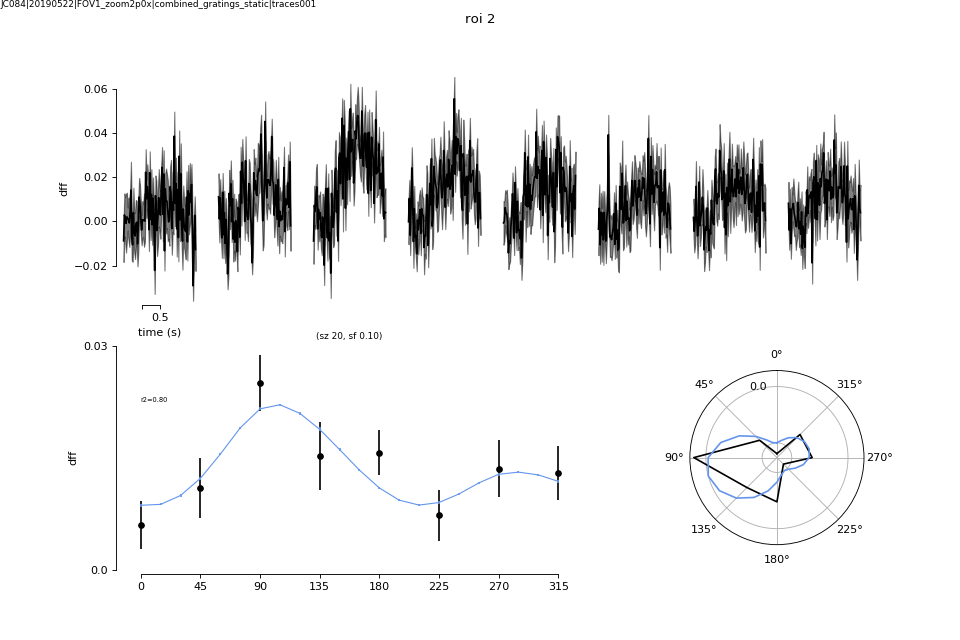

In [33]:
roi = 1
print(roi)

fit_results = []

    
roi_df = gdf.get_group(roi)
#metric_abs = np.abs(roi_df[response_type])
#roi_df[metric_type] = metric_abs

# Find best config:
best_cfg = roi_df.groupby(['config']).mean()[metric_type].idxmax()
best_cfg_params = stimdf.loc[best_cfg][[p for p in params if p!='ori']]
curr_cfgs = sorted([c for c in stimdf.index.tolist() \
                    if all(stimdf.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
                    key = lambda x: stimdf['ori'][x])


# Get all trials of current set of cfgs:
trialdf = roi_df[roi_df['config'].isin(curr_cfgs)]
rdf = trialdf[['config', 'trial', response_type]]
grouplist = [group_configs(group, response_type) for config, group in rdf.groupby(['config'])]
responses_df = pd.concat(grouplist, axis=1)

# Bootstrap distN of responses (rand w replacement):
bootdf = [responses_df.sample(60, replace=True).mean(axis=0) for ni in range(n_bootstrap_iters)]
bootstrapped_df = pd.concat(bootdf, axis=1)
bootstrapped_df.index = [sdf['ori'][c] for c in bootstrapped_df.index]

# Find init params for tuning fits and set fit constraints:
init_params = get_init_params(bootstrapped_df[0])
r_pref, r_null, theta_pref, sigma, r_offset = init_params
init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

# Interpolate values for finer steps:
asi=[];dsi=[];r2=[];
for niter in bootstrapped_df.columns:
    oris_interp = interp_values(tested_oris, n_intervals=n_intervals_interp, wrap_value=360)
    resps_interp = interp_values(bootstrapped_df[niter], n_intervals=n_intervals_interp, \
                                 wrap_value=bootstrapped_df[niter][0])


    init_params = get_init_params(bootstrapped_df[niter])
    r_pref, r_null, theta_pref, sigma, r_offset = init_params
    init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

    fail = False
    try:
        rfit = fit_direction_selectivity(oris_interp, resps_interp, init_params, bounds=init_bounds)
        asi_t = get_ASI(rfit['fit_y'][0:], oris_interp[0:])
        dsi_t = get_DSI(rfit['fit_y'][0:], oris_interp[0:])

        asi.append(asi_t)
        dsi.append(dsi_t)
        r2.append(rfit['r2'])

        rfit['x'] = oris_interp
        rfit['y'] = resps_interp
        rfit['n_intervals_interp'] = n_intervals_interp

        fit_results.append(rfit)

    except Exception as e:
        print(e)
        fail = True
        print("... skipping %i" % roi)
        break

if len(fit_results) > 0 and make_plots:
    print("... plotting")
    fig, ax, ax1, ax2 = plot_roi_tuning_raw_and_fit(roi, df_traces, labels,\
                                            curr_cfgs, stimdf, fit_results,\
                                            trace_type='dff')
    curr_oris = sorted(sdf['ori'].unique())
    ax1.set_xticks(curr_oris)
    ax1.set_xticklabels(curr_oris)
    fig.suptitle('roi %i' % int(roi+1))
    label_figure(fig, data_identifier)

# Plot and fit ROIs

In [33]:
roi_fitdir_figures = os.path.join(roi_fitdir, 'roi_fits')
if not os.path.exists(roi_fitdir_figures):
    os.makedirs(roi_fitdir_figures)
if make_plots:
    print("Saving ROI fit plots to:\n%s" % roi_fitdir_figures)

Saving ROI fit plots to:
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/Liang2018_Andermann/remove-bas_pass-ROC-thr0.05/roi_fits


In [35]:
tuning_fit_results_path = os.path.join(roi_fitdir, 'tuning_bootstrap_results.pkl')
if os.path.exists(tuning_fit_results_path):
    with open(tuning_fit_results_path, 'rb') as f:
        fitdf = pkl.load(f)
    do_fits = False
else:
    do_fits = True

In [36]:
if do_fits:

    roi_fits = []
    for ri, roi in enumerate(roi_list): #[30, 91, 93, 151]:
        fit_results = []

        # -----------------
        if ri % 20 == 0:
            print("...fitting %i of %i rois" % (ri, len(roi_list)))

        roi_df = gdf.get_group(roi)
        #metric_abs = np.abs(roi_df[response_type])
        #roi_df[metric_type] = metric_abs

        # Find best config:
        best_cfg = roi_df.groupby(['config']).mean()[metric_type].idxmax()
        best_cfg_params = stimdf.loc[best_cfg][[p for p in params if p!='ori']]
        curr_cfgs = sorted([c for c in stimdf.index.tolist() \
                            if all(stimdf.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
                            key = lambda x: stimdf['ori'][x])


        # Get all trials of current set of cfgs:
        trialdf = roi_df[roi_df['config'].isin(curr_cfgs)]
        rdf = trialdf[['config', 'trial', response_type]]
        grouplist = [group_configs(group, response_type) for config, group in rdf.groupby(['config'])]
        responses_df = pd.concat(grouplist, axis=1)

        # Bootstrap distN of responses (rand w replacement):
        bootdf = [responses_df.sample(60, replace=True).mean(axis=0) for ni in range(n_bootstrap_iters)]
        bootstrapped_df = pd.concat(bootdf, axis=1)
        bootstrapped_df.index = [sdf['ori'][c] for c in bootstrapped_df.index]

        # Find init params for tuning fits and set fit constraints:
        init_params = get_init_params(bootstrapped_df[0])
        r_pref, r_null, theta_pref, sigma, r_offset = init_params
        init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

        # Interpolate values for finer steps:
        asi=[];dsi=[];r2=[];
        for niter in bootstrapped_df.columns:
            oris_interp = interp_values(tested_oris, n_intervals=n_intervals_interp, wrap_value=360)
            resps_interp = interp_values(bootstrapped_df[niter], n_intervals=n_intervals_interp, \
                                         wrap_value=bootstrapped_df[niter][0])


            init_params = get_init_params(bootstrapped_df[niter])
            r_pref, r_null, theta_pref, sigma, r_offset = init_params
            init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

            fail = False
            try:
                rfit = fit_direction_selectivity(oris_interp, resps_interp, init_params, bounds=init_bounds)
                asi_t = get_ASI(rfit['fit_y'][0:], oris_interp[0:])
                dsi_t = get_DSI(rfit['fit_y'][0:], oris_interp[0:])

                asi.append(asi_t)
                dsi.append(dsi_t)
                r2.append(rfit['r2'])

                rfit['x'] = oris_interp
                rfit['y'] = resps_interp
                rfit['n_intervals_interp'] = n_intervals_interp

                fit_results.append(rfit)

            except Exception as e:
                print(e)
                fail = True
                print("... skipping %i" % roi)
                break

        if len(fit_results) > 0 and make_plots:
            print("... plotting")
            fig, ax, ax1, ax2 = plot_roi_tuning_raw_and_fit(roi, df_traces, labels,\
                                                    curr_cfgs, stimdf, fit_results,\
                                                    trace_type='dff')
            curr_oris = sorted(sdf['ori'].unique())
            ax1.set_xticks(curr_oris)
            ax1.set_xticklabels(curr_oris)
            fig.suptitle('roi %i' % int(roi+1))
            label_figure(fig, data_identifier)

            #-------------------------

            pl.savefig(os.path.join(roi_fitdir_figures, 'roi%05d.png' % int(roi+1)))
            pl.close()

        if not fail:
            roi_fits.append(pd.DataFrame({'ASI': asi,
                                          'DSI': dsi,
                                          'r2': r2,
                                          'cell': [roi for _ in np.arange(0, len(asi))]}))

        #print("[%i] ASI: %.3f (+/- %.3f), DSI: %.3f (+/- %.3f) (bootstrap %i iter)" % (roi, np.mean(asi), np.std(asi), np.mean(dsi), np.std(dsi), n_bootstrap_iters))


    ### Save bootstrap fit results 

    fitdf = pd.concat(roi_fits, axis=0)
    fitdf.head()
    fitdf['cell'] = [str(i) for i in fitdf['cell'].values] #fitdf['cell'].astype('category')


    with open(tuning_fit_results_path, 'wb') as f:
        pkl.dump(fitdf, f, protocol=pkl.HIGHEST_PROTOCOL)


In [37]:
fitdf.dtypes

ASI     float64
DSI     float64
cell     object
r2      float64
dtype: object

In [38]:
fitdf['ASI'].max()

0.81927299235572537

In [39]:
fitdf.head()

,ASI,DSI,cell,r2
0,0.078965,0.093148,1,0.718806
1,0.119227,0.093863,1,0.827453
2,0.111835,0.134737,1,0.804567
3,0.082858,0.113855,1,0.681597
4,0.125616,0.125116,1,0.957805


<IPython.core.display.Javascript object>


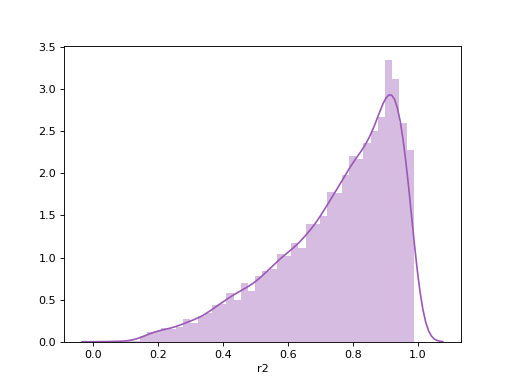

In [40]:
pl.figure()
sns.distplot(fitdf['r2'])

##### Compare metrics

In [41]:
fit_thr=0.9
[r for r, v in fitdf.groupby(['cell']) if v.mean()['r2'] >= fit_thr]

['12',
 '132',
 '147',
 '151',
 '16',
 '163',
 '166',
 '17',
 '206',
 '21',
 '210',
 '215',
 '241',
 '247',
 '255',
 '30',
 '40',
 '45',
 '54',
 '67',
 '74',
 '91',
 '93']

In [42]:
roi_fitdir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/Liang2018_Andermann/remove-bas_pass-ROC-thr0.05'

###### Look at all metrics, fit vs. all responsive

<IPython.core.display.Javascript object>


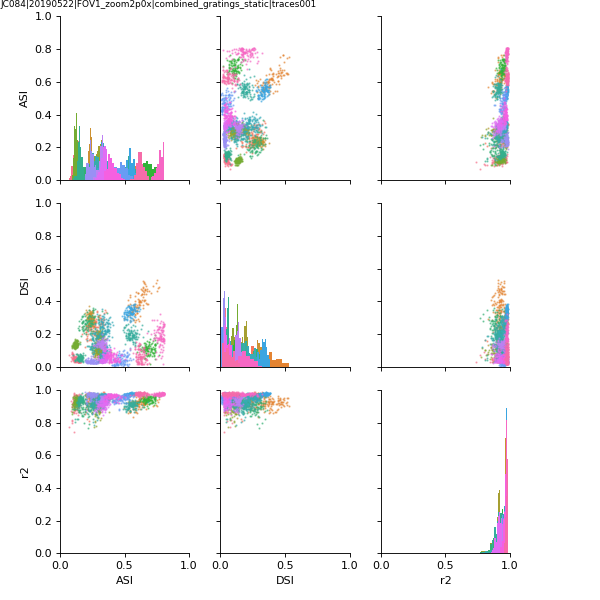

Saved:
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/Liang2018_Andermann/remove-bas_pass-ROC-thr0.05/bootstrap100_tuning_fit_thr_0.90_23of120.png


In [220]:
fit_thr = 0.9
strong_fits = [r for r, v in fitdf.groupby(['cell']) if v.mean()['r2'] >= fit_thr]


df = fitdf[fitdf['cell'].isin(strong_fits)]

nrois_attempted = len(fitdf['cell'].unique())
nrois_fit = len(df['cell'].unique())

g = sns.PairGrid(df, hue='cell', vars=['ASI', 'DSI', 'r2'])
g.fig.patch.set_alpha(1)


g = g.map_offdiag(pl.scatter, marker='o',  alpha=0.5, s=1)


g = g.map_diag(pl.hist, normed=True) #histtype="step",  

g.set(ylim=(0, 1))
g.set(xlim=(0, 1))

#sns.distplot, kde=False, hist=True, rug=True,\
               #hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})

if df.shape[0] < 10:
    g = g.add_legend(bbox_to_anchor=(1.01,.5))

pl.subplots_adjust(left=0.1, right=0.85)

#g.set(xlim=(0,1), ylim=(0,1))
#g.set(xticks=[0, 1])
#g.set(yticks=[0, 1])
#sns.despine(trim=True)
        
cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
cleanup_axes( g.axes[:-1, :].flat, which_axis='x')

label_figure(g.fig, data_identifier)

figname = 'bootstrap%i_tuning_fit_thr_%.2f_%iof%i' % (n_bootstrap_iters, fit_thr,
                                                     nrois_fit, nrois_attempted)

pl.savefig(os.path.join(roi_fitdir, '%s.png' % figname))
#pl.close()
print("Saved:\n%s" % os.path.join(roi_fitdir, '%s.png' % figname))


In [110]:
df.dtypes

ASI        float64
DSI        float64
cell        object
r2         float64
top_asi      int64
top_dsi      int64
dtype: object

##### Sort by high ASI or DSI

In [228]:
fit_thr = 0.9
strong_fits = [r for r, v in fitdf.groupby(['cell']) if v.mean()['r2'] >= fit_thr]
print("%i out of %i cells with strong fits (%.2f)" % (len(strong_fits), len(fitdf['cell'].unique()), fit_thr))

df = fitdf[fitdf['cell'].isin(strong_fits)]


23 out of 120 cells with strong fits (0.90)


In [229]:
df.head()

,ASI,DSI,cell,r2
0,0.091378,0.077283,12,0.896728
1,0.114010,0.053626,12,0.954918
2,0.138658,0.029739,12,0.848803
3,0.146662,0.028656,12,0.899279
4,0.111583,0.052185,12,0.963697


In [230]:
df.loc[:, 'cell'] = np.array([int(c) for c in df['cell'].values])

In [231]:
top_asi = df.groupby(['cell']).mean().sort_values(['ASI'], ascending=False)
top_dsi = df.groupby(['cell']).mean().sort_values(['DSI'], ascending=False)
top_r2 = df.groupby(['cell']).mean().sort_values(['r2'], ascending=False)

top_asi_cells = top_asi.index.tolist()[0:10]
top_dsi_cells = top_dsi.index.tolist()[0:10]
top_r2_cells = top_r2.index.tolist()[0:10]

In [232]:
top_asi_cells

[91, 206, 93, 147, 215, 30, 40, 74, 247, 67]

In [233]:
top10_asi = [roi for rank, roi in enumerate(top_asi.index.tolist()) if rank < 10]
top10_dsi = [roi for rank, roi in enumerate(top_dsi.index.tolist()) if rank < 10]
top10_asi

[91, 206, 93, 147, 215, 30, 40, 74, 247, 67]

In [234]:
top_asi.shape

(23, 3)

In [235]:
df.loc[:, 'top_asi'] = np.array([ roi if roi in top10_asi else -10 for roi in df['cell']])
df.loc[:, 'top_dsi'] = np.array([ roi if roi in top10_dsi else -10 for roi in df['cell']])


In [236]:
df['top_asi'].unique()

array([-10,  30,  40,  67,  74,  91,  93, 147, 206, 215, 247])

In [237]:

# df['cell'] = df['cell'].astype(int)
# df['top_asi'] = np.zeros(df.shape[0]) ##*-100
# df['top_dsi'] = np.zeros(df.shape[0])# *-100

# #for rank, roi in zip(np.arange(100, 100+len(top_asi_cells))[::-1], top_asi_cells):
# for rank, roi in enumerate(top_asi.index.tolist()):
#     if rank < 10:
#         df.loc[df['cell']==roi, 'top_asi'] = roi
#     else:
#         df.loc[df['cell']==roi, 'top_asi'] = -10

# for rank, roi in enumerate(top_dsi.index.tolist()):
#     if rank < 10:
#         df.loc[df['cell']==roi, 'top_dsi'] = roi
#     else:
#         df.loc[df['cell']==roi, 'top_dsi'] = -10


In [238]:
df.loc[:, 'top_asi'] = [str(s) for s in df['top_asi'].values]
df.loc[:, 'top_dsi'] = [str(s) for s in df['top_dsi'].values]


In [239]:
palette = sns.color_palette('cubehelix', len(top_asi_cells))
main_alpha = 0.8
sub_alpha = 0.01
asi_colordict = dict(( str(roi), palette[i]) for i, roi in enumerate(top_asi_cells))
for k, v in asi_colordict.items():
    asi_colordict[k] = (v[0], v[1], v[2], main_alpha)
    
dsi_colordict = dict(( str(roi), palette[i]) for i, roi in enumerate(top_dsi_cells))
for k, v in dsi_colordict.items():
    dsi_colordict[k] = (v[0], v[1], v[2], main_alpha)
    
    
asi_colordict.update({ str(-10): (0.8, 0.8, 0.8, sub_alpha)})
dsi_colordict.update({ str(-10): (0.8, 0.8, 0.8, sub_alpha)})


In [240]:
asi_colordict

{'-10': (0.8, 0.8, 0.8, 0.01),
 '147': (0.23627685553553793, 0.46114369021199075, 0.19770731888985724, 0.8),
 '206': (0.091597265588691884, 0.20394337960213008, 0.29623965888210324, 0.8),
 '215': (0.49498740849493095, 0.47990348691590418, 0.21147789468974837, 0.8),
 '247': (0.75884246923722409, 0.82539903534204739, 0.95426993312205877, 0.8),
 '30': (0.73545265134739812, 0.47488619035710461, 0.40254094042448907, 0.8),
 '40': (0.83259285298532915, 0.52534467578447441, 0.68693769318653541, 0.8),
 '67': (0.83856452116838021, 0.9411869386771845, 0.9357655639413166, 0.8),
 '74': (0.79369206322753694, 0.66413372114337088, 0.90423118430625293, 0.8),
 '91': (0.098542283639501141, 0.071152155722950819, 0.16957891809124037, 0.8),
 '93': (0.094066117999301618, 0.35788714126080978, 0.28377097117228661, 0.8)}

In [241]:
df['top_asi'].unique()


array(['-10', '30', '40', '67', '74', '91', '93', '147', '206', '215',
       '247'], dtype=object)

In [242]:
df.dtypes

ASI        float64
DSI        float64
cell         int64
r2         float64
top_asi     object
top_dsi     object
dtype: object

In [243]:
df.head()

,ASI,DSI,cell,r2,top_asi,top_dsi
0,0.091378,0.077283,12,0.896728,-10,-10
1,0.114010,0.053626,12,0.954918,-10,-10
2,0.138658,0.029739,12,0.848803,-10,-10
3,0.146662,0.028656,12,0.899279,-10,-10
4,0.111583,0.052185,12,0.963697,-10,-10


<IPython.core.display.Javascript object>


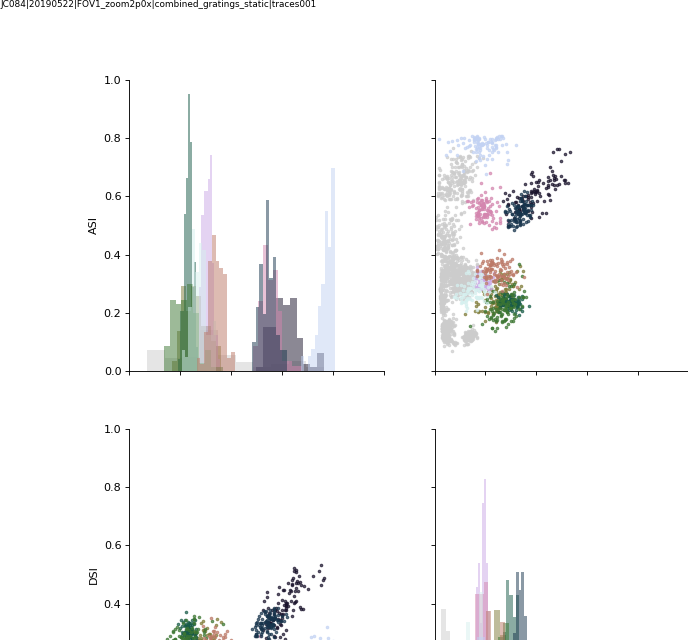

In [244]:
nrois_attempted = len(fitdf['cell'].unique())
nrois_fit = len(df['cell'].unique())

color_by = 'DSI'

#df.loc[:, 'cell'] = np.array([str(c) for c in df['cell'].values])
#df.loc[:, 'top_asi'] = np.array([float(c) for c in df['top_asi'].values])
#df.loc[:, 'top_dsi'] = np.array([float(c) for c in df['top_dsi'].values])

if color_by == 'ASI':
    hue = 'top_asi'
    palette = asi_colordict
    #cells = copy.copy(top_asi_cells)
elif color_by == 'DSI':
    hue = 'top_dsi'
    palette = dsi_colordict
    #cells = copy.copy(top_dsi_cells)

#palette = 'cubehelix'
g = sns.PairGrid(df, hue=hue, vars=['ASI', 'DSI'], palette=palette, size=5)#,
                #hue_kws={"alpha": alphadict.values()}) # 'cubehelix_r') #'cubehelix') #'')

g.fig.patch.set_alpha(1)
g = g.map_offdiag(pl.scatter, marker='o', s=5, alpha=0.7) #, color=[asi_colordict[r] for r in ddf[hue]]) #=alphadict.values()[::-1]) #,  alpha=0.5, s=5, )


g = g.map_diag(pl.hist, normed=True, alpha=0.5) #histtype="step",  


g.set(ylim=(0, 1))
g.set(xlim=(0, 1))

g = g.add_legend(bbox_to_anchor=(1.0,0.2))
for li, lh in enumerate(g._legend.legendHandles): 
    if not all([round(l, 1)==0.5 for l in lh.get_facecolor()[0][0:3]]):
        
        lh.set_alpha(1)
        lh._sizes = [20] 
    
pl.subplots_adjust(left=0.15, right=0.8, top=0.9, bottom=0.1, wspace=0.2, hspace=0.2)

#g.set(xlim=(0,1), ylim=(0,1))
#g.set(xticks=[0, 1])
#g.set(yticks=[0, 1])
#sns.despine(trim=True)
        
cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
cleanup_axes( g.axes[:-1, :].flat, which_axis='x')

label_figure(g.fig, data_identifier)

figname = 'bootstrap%i_tuning_fit_thr_%.2f_%iof%i_colortop10_%s' % (n_bootstrap_iters, fit_thr,
                                                      nrois_fit, nrois_attempted, color_by)

pl.savefig(os.path.join(roi_fitdir, '%s.png' % figname))
#pl.close()
#print("Saved:\n%s" % os.path.join(roi_fitdir, '%s.png' % figname))


In [68]:
top_asi_cells

[91, 67, 205, 206, 255, 135, 25, 30, 151, 247]

In [69]:
top_dsi_cells

[30, 151, 247, 137, 91, 206, 255, 135, 25, 67]

<IPython.core.display.Javascript object>


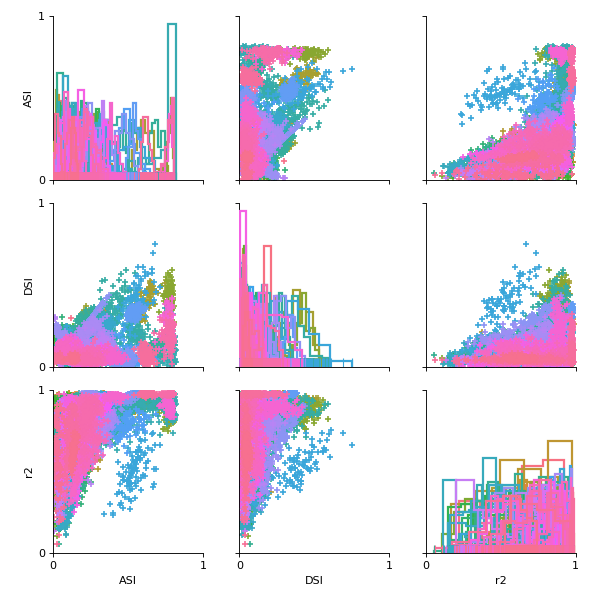

In [245]:

g = sns.PairGrid(fitdf, hue='cell', vars=['ASI', 'DSI', 'r2'])

g = g.map_diag(sns.distplot, kde=False, hist=True, rug=True,\
               hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})
g = g.map_offdiag(pl.scatter, marker='+')

g.set(xlim=(0,1), ylim=(0,1))
g.set(xticks=[0, 1])
g.set(yticks=[0, 1])
sns.despine(trim=True)

cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
cleanup_axes( g.axes[:-1, :].flat, which_axis='x')



<IPython.core.display.Javascript object>


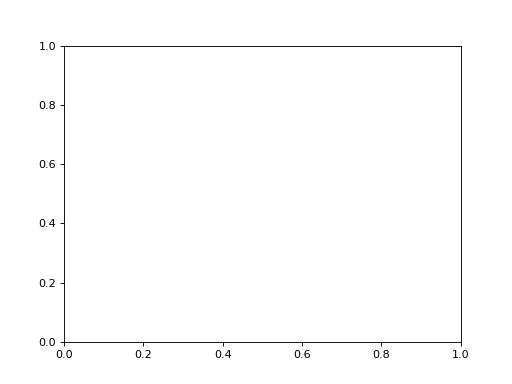

TypeError: string indices must be integers, not str

In [224]:
fig, ax = pl.subplots()
for br in fitdf:
    ax.plot(oris_interp, br['fit_y'])

In [225]:
asi = get_ASI(rfit['fit_y'], oris_interp)
dsi = get_DSI(rfit['fit_y'], oris_interp)
print("ASI: %.2f, DSI: %.2f" % (asi, dsi))

NameError: name 'rfit' is not defined

In [32]:
x = rdf.groupby(['config']).apply(group_configs, response_type)


ValueError: Plan shapes are not aligned

In [30]:
x.shape

(1240, 1)

In [25]:
pd.DataFrame(data=rdf.groupby(['config'])['dff'].apply(np.array).values)

,0
0,"[0.197346476826, 0.0189041892801, 0.1106356293..."
1,"[0.336630562764, 0.475683342706, 0.47338181193..."
2,"[0.0508394282838, 0.0627176877596, 0.019022855..."
3,"[0.122029687788, 0.662941280718, 0.46299090975..."
4,"[0.334152229015, -0.117570336881, -0.080865504..."
5,"[0.132585848871, 0.108803858515, 0.22346681209..."
6,"[0.415117818805, 0.11178881399, 0.231719181844..."
7,"[-0.034004940764, 0.45328845876, 0.53898263135..."
8,"[-0.185469417564, -0.0446771156282, 0.02680228..."
9,"[0.529325203276, 0.292090651618, 0.37291062689..."
